In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import numpy as np

from torch.utils.data import DataLoader

from dataloaders.nyu_v2_dataloader import NYU_v2_Customize
from envs.blockdrop_env import BlockDropEnv
from test_sample import eval_fix_policy
import torch
from utils.util import print_separator, read_yaml, create_path, print_yaml
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

import argparse
import yaml

import cv2
cv2.__version__

'4.5.3'

In [4]:
input_args = " --config  yamls/adashare/nyu_v2_3task_test.yml --cpu ".split()
# pretrained_path = "/mnt/f/models_adashare/NYU_v2_3Task_pretrain"
print(input_args)
# print(pretrained_path)

['--config', 'yamls/adashare/nyu_v2_3task_test.yml', '--cpu']


In [5]:
def eval_fix_policy(environ, dataloader, tasks, num_seg_cls=-1, eval_iter=10):
    batch_size = []
    records = {}
    val_metrics = {}

    ## Initialize metric data structures for each task type
    if 'seg' in tasks:
        assert (num_seg_cls != -1)
        records['seg'] = {'mIoUs': [], 'pixelAccs': [], 'errs': [], 'conf_mat': np.zeros((num_seg_cls, num_seg_cls)),
                          'labels': np.arange(num_seg_cls), 'gts': [], 'preds': []}
    if 'sn' in tasks:
        records['sn'] = {'cos_similaritys': []}
    if 'depth' in tasks:
        records['depth'] = {'abs_errs': [], 'rel_errs': [], 'sq_rel_errs': [], 'ratios': [], 'rms': [], 'rms_log': []}
    if 'keypoint' in tasks:
        records['keypoint'] = {'errs': []}
    if 'edge' in tasks:
        records['edge'] = {'errs': []}

    with torch.no_grad():
        
        for batch_idx, batch in enumerate(tqdm(dataloader)):
            if eval_iter != -1:
                if batch_idx > eval_iter:
                    break
                    
                    
            environ.set_inputs(batch)
            
            metrics = environ.val_fix_policy()
            
            if 'seg' in tasks:
                records['seg']['gts'].append(metrics['seg']['gt'])
                records['seg']['preds'].append(metrics['seg']['pred'])
                new_mat = confusion_matrix(metrics['seg']['gt'], metrics['seg']['pred'], records['seg']['labels'])
                assert (records['seg']['conf_mat'].shape == new_mat.shape)
                records['seg']['conf_mat'] += new_mat
                records['seg']['pixelAccs'].append(metrics['seg']['pixelAcc'])
                records['seg']['errs'].append(metrics['seg']['err'])
            if 'sn' in tasks:
                records['sn']['cos_similaritys'].append(metrics['sn']['cos_similarity'])
            if 'depth' in tasks:
                records['depth']['abs_errs'].append(metrics['depth']['abs_err'])
                records['depth']['rel_errs'].append(metrics['depth']['rel_err'])
                records['depth']['sq_rel_errs'].append(metrics['depth']['sq_rel_err'])
                records['depth']['ratios'].append(metrics['depth']['ratio'])
                records['depth']['rms'].append(metrics['depth']['rms'])
                records['depth']['rms_log'].append(metrics['depth']['rms_log'])
            if 'keypoint' in tasks:
                records['keypoint']['errs'].append(metrics['keypoint']['err'])
            if 'edge' in tasks:
                records['edge']['errs'].append(metrics['edge']['err'])
            batch_size.append(len(batch['img']))

    if 'seg' in tasks:
        val_metrics['seg'] = {}
        jaccard_perclass = []
        for i in range(num_seg_cls):
            if not records['seg']['conf_mat'][i, i] == 0:
                jaccard_perclass.append(records['seg']['conf_mat'][i, i] / (np.sum(records['seg']['conf_mat'][i, :]) +
                                                                            np.sum(records['seg']['conf_mat'][:, i]) -
                                                                            records['seg']['conf_mat'][i, i]))

        val_metrics['seg']['mIoU'] = np.sum(jaccard_perclass) / len(jaccard_perclass)

        val_metrics['seg']['Pixel Acc'] = (np.array(records['seg']['pixelAccs']) * np.array(batch_size)).sum() / sum(
            batch_size)

        val_metrics['seg']['err'] = (np.array(records['seg']['errs']) * np.array(batch_size)).sum() / sum(batch_size)

    if 'sn' in tasks:
        val_metrics['sn'] = {}
        overall_cos = np.clip(np.concatenate(records['sn']['cos_similaritys']), -1, 1)

        angles = np.arccos(overall_cos) / np.pi * 180.0
        val_metrics['sn']['Angle Mean'] = np.mean(angles)
        val_metrics['sn']['Angle Median'] = np.median(angles)
        val_metrics['sn']['Angle 11.25'] = np.mean(np.less_equal(angles, 11.25)) * 100
        val_metrics['sn']['Angle 22.5'] = np.mean(np.less_equal(angles, 22.5)) * 100
        val_metrics['sn']['Angle 30'] = np.mean(np.less_equal(angles, 30.0)) * 100
        val_metrics['sn']['Angle 45'] = np.mean(np.less_equal(angles, 45.0)) * 100

    if 'depth' in tasks:
        val_metrics['depth'] = {}
        records['depth']['abs_errs'] = np.stack(records['depth']['abs_errs'], axis=0)
        records['depth']['rel_errs'] = np.stack(records['depth']['rel_errs'], axis=0)
        records['depth']['ratios'] = np.concatenate(records['depth']['ratios'], axis=0)
        val_metrics['depth']['abs_err'] = (records['depth']['abs_errs'] * np.array(batch_size)).sum() / sum(batch_size)
        val_metrics['depth']['rel_err'] = (records['depth']['rel_errs'] * np.array(batch_size)).sum() / sum(batch_size)
        val_metrics['depth']['sigma_1.25'] = np.mean(np.less_equal(records['depth']['ratios'], 1.25)) * 100
        val_metrics['depth']['sigma_1.25^2'] = np.mean(np.less_equal(records['depth']['ratios'], 1.25 ** 2)) * 100
        val_metrics['depth']['sigma_1.25^3'] = np.mean(np.less_equal(records['depth']['ratios'], 1.25 ** 3)) * 100

    if 'keypoint' in tasks:
        val_metrics['keypoint'] = {}
        val_metrics['keypoint']['err'] = (np.array(records['keypoint']['errs']) * np.array(batch_size)).sum() / sum(
            batch_size)

    if 'edge' in tasks:
        val_metrics['edge'] = {}
        val_metrics['edge']['err'] = (np.array(records['edge']['errs']) * np.array(batch_size)).sum() / sum(
            batch_size)

    return val_metrics


In [9]:
def read_yaml(input_args):
    # read in yaml
    parser = argparse.ArgumentParser()
    parser.add_argument("--config", required=True, help="Path for the config file")
    parser.add_argument("--exp_ids", type=int, nargs='+', default=[0], help="Path for the config file")
    parser.add_argument("--gpus", type=int, nargs='+', default=[0], help="Path for the config file")
    parser.add_argument("--cpu", default=False, action="store_true",  help="CPU instead of GPU")
    args = parser.parse_args(input_args)

    print(vars(args))
    # torch.cuda.set_device(args.gpu)
    with open(args.config) as f:
        opt = yaml.load(f)
    opt['cpu'] = args.cpu
    return opt, args.gpus, args.exp_ids

## Create folders and print options 

In [10]:
# # ********************************************************************
# # ****************** create folders and print options ****************
# # ********************************************************************
print_separator('READ YAML')
opt, gpu_ids, exp_ids = read_yaml(input_args)

# for i in opt:
#     print(f'{i:24s}: {opt[i]} ')
# print(f'gpus: {gpu_ids}  \nexp_ids: {exp_ids}')

##################################################
####################READ YAML#####################
##################################################
{'config': 'yamls/adashare/nyu_v2_3task_test.yml', 'exp_ids': [0], 'gpus': [0], 'cpu': True}


<ipython-input-9-6ef41f77d514>:13: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  opt = yaml.load(f)


In [12]:
# fix_random_seed(opt["seed"])
create_path(opt)
# print yaml on the screen
lines = print_yaml(opt)
for line in lines: print(line)
# print to file
filename = os.path.join(opt['paths']['log_dir'], opt['exp_name'], 'opt.txt')
print(f'\nWrite opts to {filename}')
with open(os.path.join(opt['paths']['log_dir'], opt['exp_name'], 'opt.txt'), 'w+') as f:
    f.writelines(lines)


exp_name. : NYU_v2_3Task_pretrain
seed. : [48]
backbone. : ResNet34
tasks. : ['seg', 'sn', 'depth']
tasks_num_class. : [40, 3, 1]
lambdas. : [1, 20, 3]
policy_model. : task-specific
paths.
paths.log_dir. : ../experiments/logs
paths.result_dir. : ../experiments/results
paths.orig_checkpoint_dir. : ../experiments/checkpoints
paths.checkpoint_dir. : /mnt/f/models_adashare
dataload.
dataload.dataset. : NYU_v2
dataload.dataroot. : ./nyu_v2_samples/
dataload.original_dataroot. : /data/datasets/nyu_v2
dataload.crop_h. : 321
dataload.crop_w. : 321
policy. : True
init_neg_logits. : None
is_sparse. : True
is_sharing. : True
skip_layer. : 0
is_curriculum. : True
curriculum_speed. : 3
fix_BN. : False
diff_sparsity_weights. : True
retrain_from_pl. : False
train.
train.policy_iter. : best
train.which_iter. : warmup
train.init_method. : equal
train.hard_sampling. : False
test.
test.which_iter. : best
cpu. : True

Write opts to ../experiments/logs/NYU_v2_3Task_pretrain/opt.txt


## Prepare dataloaders

In [13]:
# ********************************************************************
# ******************** Prepare the dataloaders ***********************
# ********************************************************************
# load the dataloader
print_separator('CREATE DATALOADERS')
print(f"Dataroot is {opt['dataload']['dataroot']}")

assert opt['dataload']['dataset'] == 'NYU_v2'
valset = NYU_v2_Customize(opt['dataload']['dataroot'], 'test')
print('size of validation set: ', len(valset))

val_loader = DataLoader(valset, batch_size=1, drop_last=True, num_workers=2, shuffle=False)

##################################################
################CREATE DATALOADERS################
##################################################
Dataroot is ./nyu_v2_samples/
NYU_v2_Customize
None
size of validation set:  4


## Create the Environment

In [14]:
# ********************************************************************
# ********************Create the environment *************************
# ********************************************************************
# create the model and the pretrain model
print_separator('CREATE THE ENVIRONMENT')
environ = BlockDropEnv(opt['paths']['log_dir'], opt['paths']['checkpoint_dir'], opt['exp_name'],
                       opt['tasks_num_class'], device=gpu_ids[0], is_train=False, opt=opt)

environ_load_parm = 'retrain%03d_policyIter%s_best' % (exp_ids[0], opt['train']['policy_iter'])
print(f" environ.load({environ_load_parm})")

current_iter = environ.load('retrain%03d_policyIter%s_best' % (exp_ids[0], opt['train']['policy_iter']))
# current_iter = environ.load( environ_load_parm, path=pretrained_path)

print('Evaluating the snapshot saved at %d iter' % current_iter)


##################################################
##############CREATE THE ENVIRONMENT##############
##################################################
BlockDropEnv
Create MTL2 with 
 block: <class 'models.base.BasicBlock'> 
 layers: [3, 4, 6, 3] 
 tasks_num_class: [40, 3, 1] 
 init_method: equal
 environ.load(retrain000_policyIterbest_best)
=> loading snapshot from /mnt/f/models_adashare/NYU_v2_3Task_pretrain/retrain000_policyIterbest_best_model.pth.tar
Loading to CPU
Evaluating the snapshot saved at 17200 iter


In [15]:
environ.networks['mtl-net']

MTL2(
  (backbone): Deeplab_ResNet_Backbone(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
    (blocks): ModuleList(
      (0): ModuleList(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchN

#### Policies

In [16]:
environ.networks['mtl-net'].policys

[None, None, None]

In [27]:
for task in environ.opt['tasks']:
    pp = (getattr(environ, '%s_policy' % task))
    print(' policy : {pp}')

AttributeError: 'BlockDropEnv' object has no attribute 'seg_policy'

In [23]:
environ.__dict__

{'init_neg_logits': -10,
 'temp': 5,
 '_tem_decay': 0.965,
 'num_tasks': 3,
 'checkpoint_dir': '/mnt/f/models_adashare/NYU_v2_3Task_pretrain',
 'log_dir': '../experiments/logs/NYU_v2_3Task_pretrain',
 'is_train': False,
 'tasks_num_class': [40, 3, 1],
 'device_id': 0,
 'opt': {'exp_name': 'NYU_v2_3Task_pretrain',
  'seed': [48],
  'backbone': 'ResNet34',
  'tasks': ['seg', 'sn', 'depth'],
  'tasks_num_class': [40, 3, 1],
  'lambdas': [1, 20, 3],
  'policy_model': 'task-specific',
  'paths': {'log_dir': '../experiments/logs',
   'result_dir': '../experiments/results',
   'orig_checkpoint_dir': '../experiments/checkpoints',
   'checkpoint_dir': '/mnt/f/models_adashare'},
  'dataload': {'dataset': 'NYU_v2',
   'dataroot': './nyu_v2_samples/',
   'original_dataroot': '/data/datasets/nyu_v2',
   'crop_h': 321,
   'crop_w': 321},
  'policy': True,
  'init_neg_logits': None,
  'is_sparse': True,
  'is_sharing': True,
  'skip_layer': 0,
  'is_curriculum': True,
  'curriculum_speed': 3,
  'fix_

In [21]:
print(opt['train']['policy_iter'], environ.num_tasks)

best 3


In [22]:
print('Evaluating the snapshot saved at %d iter' % current_iter)

policy_label = 'Iter%s_rs%04d' % (opt['train']['policy_iter'], opt['seed'][exp_ids[0]])
# policy_label = os.path.join(pretrained_path ,policy_label)
print(f"Check and load policy {policy_label}")

if environ.check_exist_policy(policy_label):
    environ.load_policy(policy_label)


Evaluating the snapshot saved at 17200 iter
Check and load policy Iterbest_rs0048
setting policy1 attribute ....
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])
setting policy2 attribute ....
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])
setting policy3 attribute ....
tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])


In [26]:
policys = environ.get_current_policy()

get policy1
get policy2
get policy3


In [16]:
overall_policy = np.concatenate(policys, axis=-1)
print(overall_policy)

[[1 0 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 0 0 1]
 [0 1 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 0 1 1 0]
 [1 0 0 1 0 1]
 [1 0 0 1 0 1]
 [1 0 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 0 1 0]
 [1 0 1 0 1 0]]


In [17]:
getattr(environ, 'policy1')

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])

In [28]:
if torch.cuda.is_available():
    environ.cuda(gpu_ids)
else:
    environ.cpu()

 Network item mtl-net moved to cpu
environ.cpu policy: [tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]]), tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [0, 1],
        [0, 1],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]])]


In [29]:
num_seg_class = opt['tasks_num_class'][opt['tasks'].index('seg')] if 'seg' in opt['tasks'] else -1

print(num_seg_class)

40


In [30]:
## Set model to evaluation mode
environ.eval()

### `eval_fix_policy()`

In [33]:
# val_metrics = eval_fix_policy(environ, val_loader, opt['tasks'], num_seg_cls=num_seg_class, eval_iter=-1)

# print(val_metrics)

In [36]:
tasks = opt['tasks']
num_seg_cls = num_seg_class
eval_iter = -1
print(tasks)
print(num_seg_class, eval_iter)

['seg', 'sn', 'depth']
40 -1


In [37]:
batch_size = []
records = {}
val_metrics = {}

## Initialize metric data structures for each task type
if 'seg' in tasks:
    assert (num_seg_cls != -1)
    records['seg'] = {'mIoUs': [], 
                      'pixelAccs': [], 
                      'errs': [], 
                      'conf_mat': np.zeros((num_seg_cls, num_seg_cls)),
                      'labels': np.arange(num_seg_cls), 
                      'gts': [], 
                      'preds': []}
if 'sn' in tasks:
    records['sn'] = {'cos_similaritys': []}
if 'depth' in tasks:
    records['depth'] = {'abs_errs': [], 'rel_errs': [], 'sq_rel_errs': [], 'ratios': [], 'rms': [], 'rms_log': []}
if 'keypoint' in tasks:
    records['keypoint'] = {'errs': []}
if 'edge' in tasks:
    records['edge'] = {'errs': []}


In [38]:
print(records)

{'seg': {'mIoUs': [], 'pixelAccs': [], 'errs': [], 'conf_mat': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), 'labels': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39]), 'gts': [], 'preds': []}, 'sn': {'cos_similaritys': []}, 'depth': {'abs_errs': [], 'rel_errs': [], 'sq_rel_errs': [], 'ratios': [], 'rms': [], 'rms_log': []}}


In [42]:
batch  = next(iter(val_loader))

#### Display contents of batch

In [56]:
print(type(batch))
for i in batch :
    if isinstance(batch[i], torch.Tensor):
        print(f'i: {i}   type: {type(batch[i])}   size: {batch[i].shape}' )
    else:
        print(f'i: {i}   type: {type(batch[i])}   len: {len(batch[i])}   [{batch[i][0]}] '  )

<class 'dict'>
i: img   type: <class 'torch.Tensor'>   size: torch.Size([1, 3, 480, 640])
i: seg   type: <class 'torch.Tensor'>   size: torch.Size([1, 1, 480, 640])
i: normal   type: <class 'torch.Tensor'>   size: torch.Size([1, 3, 480, 640])
i: depth   type: <class 'torch.Tensor'>   size: torch.Size([1, 1, 480, 640])
i: name   type: <class 'list'>   len: 1   [0774.png] 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


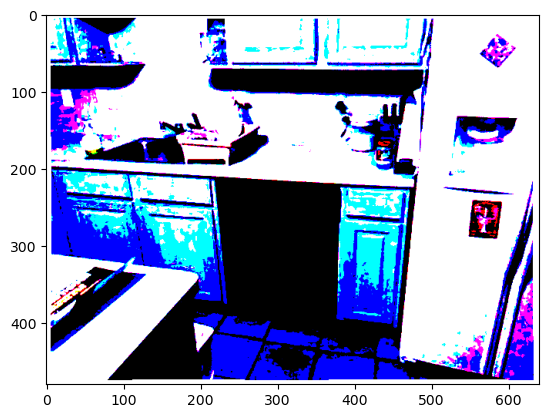

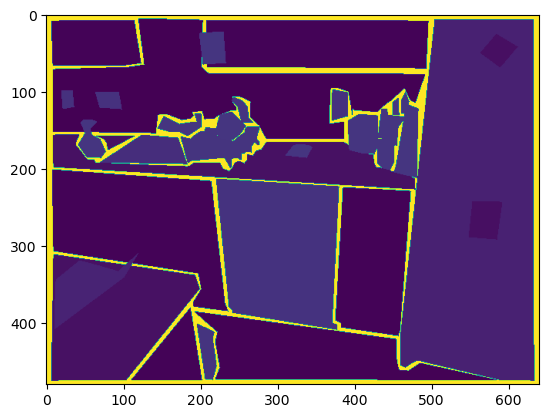

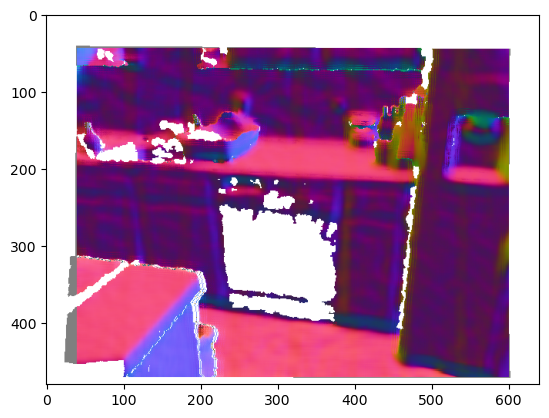

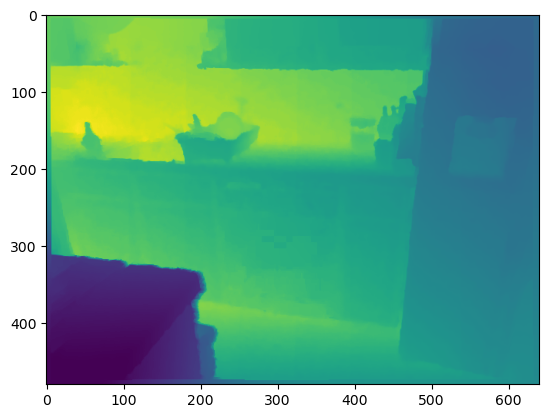

In [69]:
import matplotlib.pyplot as plt
plt.imshow(np.transpose(batch['img'].squeeze(),(1,2,0))) ## , cmap="gray")
plt.show()
plt.imshow(batch['seg'].squeeze()) ## , cmap="gray")
plt.show()
plt.imshow(np.transpose(batch['normal'].squeeze(),(1,2,0))) ## , cmap="gray")
plt.show()
plt.imshow(batch['depth'].squeeze()) ## , cmap="gray")
plt.show()


#### 

In [70]:
environ.set_inputs(batch)

In [24]:
environ.networks.keys()

dict_keys(['mtl-net'])

In [1]:
5000 % 5

0